# RNN-DAS: A New Deep Learning Approach for Detection and Real-Time Monitoring of Volcano-Tectonic Events Using Distributed Acoustic Sensing

This notebook demonstrates how the RNN-DAS model works and how to use it. The model was developed using Recurrent Neural Networks (RNN) with Long Short-Term Memory (LSTM) units applied to Distributed Acoustic Sensing (DAS) data from volcano-tectonic (VT) events during the 2021 eruption on La Palma.

In this code, we showcase the functionality of the model by running it on a 3-minute signal example from an event with a magnitude of Ml=4.04.

The main objective of this notebook is to show how the RNN-DAS model operates and to facilitate its dissemination. It is subject to the same terms and conditions as the rest of the GitHub repository, and could be updated in the future. If you use this model or code, proper citation of the article associated with the model is required.

## Citation
If you use the model, please reference the article:

> [RNN-DAS: A New Deep Learning Approach for Detection and Real-Time Monitoring of Volcano-Tectonic Events Using Distributed Acoustic Sensing](URL_to_the_article) 


In [1]:
# Library importation
import os
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
import obspy
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import sys
scripts_path = os.path.abspath(os.path.join("..", "scripts"))
sys.path.append(scripts_path)
from Pre_processing import process_H
from model_RNN_DAS import load_model
from Features import features
from run_RNN_das import run_model
from grammar import grammar
from plots import plot_das_bi, plot_das_grammar, plot_stacked_traces_normalized
from picks import write_pickle, detect_phases
from picks import extract_events_to_mseed

In [2]:
# Load the data
def load_h5(name_id, path="H5_data"):
    """
    Load the data from an HDF5 file.

    Args:
        name_id (str): The ID used to find the corresponding H5 file.
        path (str): The directory where the H5 file is located. Default is "H5_data".

    Returns:
        data (numpy.ndarray): The data stored in the H5 file, should be a channels x time_steps 2D matrix .
        dt_s (float): The time step in seconds (from the "dt_s" attribute).
        dx_m (float): The spatial step in meters (from the "dx_m" attribute).
        begin_date (str): The begin time stored in the "begin_time" attribute (ISO 8601 format).
    """
    # Construct the full path to the H5 file
    file_path = os.path.join(path, f"{name_id}.h5")
    
    # Open the H5 file and read the data and attributes
    with h5py.File(file_path, "r") as fp:
        data = np.array(fp["data"])
        dt_s = fp["data"].attrs["dt_s"]
        dx_m = fp["data"].attrs["dx_m"]
        begin_date = fp["data"].attrs["begin_time"]
    
    # Return the loaded data and attributes
    return data, dt_s, dx_m, begin_date

H, dt, dx, start_time = load_h5("d_c_20211120_064137_064337") #event_id= d_20211120_064137_064337 but only the first 100 channels for memory sake in the GitHub repository

In [3]:
# Pre-processing of the data
H=process_H(H[:, :], dt)

>> Processing DAS data...
>> Processing complete


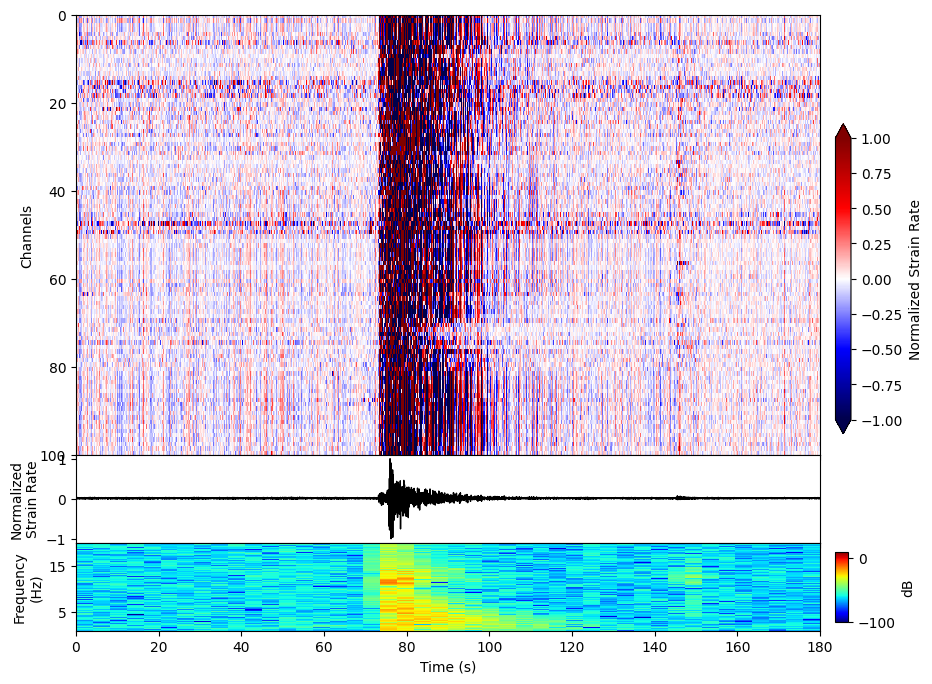

In [4]:
# Visualizing the data



data_selected = H[:, :]
num_channels = data_selected.shape[0]
time_steps = data_selected.shape[1]
fsamp = 100  

z_score_normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
min_max_normalize = lambda x: 2 * (x - np.min((x), axis=-1, keepdims=True)) / (np.max((x), axis=-1, keepdims=True) - np.min((x), axis=-1, keepdims=True)) - 1

data_selected = (z_score_normalize(data_selected))
signal = min_max_normalize(data_selected[40, :])
frequencies, times, Sxx = spectrogram(signal, fs=fsamp, nfft=1024, nperseg=600, noverlap=200)

fig, axs = plt.subplots(
    3, 1, figsize=(10, 8), 
    gridspec_kw={'height_ratios': [5, 1, 1], 'hspace': 0},
    sharex=True
)

im = axs[0].imshow(
    data_selected,
    cmap="seismic",
    vmin=-1,
    vmax=1,
    aspect="auto",
    extent=[0, time_steps / fsamp, num_channels, 0],
    interpolation="none"
)
axs[0].set_ylabel('Channels')
axs[0].tick_params(labelbottom=False)

im2=axs[2].imshow(
    10 * np.log10(Sxx),
    cmap='jet',
    aspect='auto',
    extent=[0, time_steps / fsamp, frequencies[-1], frequencies[0]],
    interpolation='none',
    vmin=-100,
    vmax=10
)
axs[2].set_ylabel('Frequency\n(Hz)')
axs[2].set_ylim(1, 20)
axs[2].set_yticks([5, 15])
axs[1].plot(np.arange(time_steps) / fsamp, signal, color='black', lw=1)
axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel('Normalized\nStrain Rate')
axs[2].set_xlim(axs[0].get_xlim())
cbar1 = fig.colorbar(im, ax=axs[:2], orientation='vertical', fraction=0.02, pad=0.02, extend='both')
cbar1.set_label('Normalized Strain Rate')
cbar2 = fig.colorbar(im2, ax=axs[2], orientation='vertical', fraction=0.02, pad=0.02, aspect=5.5, shrink=0.8)
cbar2.set_label('dB')
plt.show()


In [19]:
# Load the pretrained RNN-DAS model

n_inputs = 144
n_hidden = 256
n_layers = 1
n_classes = 3
cell_type = "LSTM"
filepath_normalization=r"..\model\Normalization_RNN-DAS_1150.txt"#r"..\model\Normalization_RNN_DAS_1150_V2"
model_RNN_DAS=load_model(r"..\model\RNN-DAS_1150", n_inputs, n_hidden, n_layers, n_classes, cell_type)
model_RNN_DAS

Model(
  (drnn): DRNN(
    (cells): Sequential(
      (0): LSTM(144, 256)
      (1): Linear(in_features=256, out_features=3, bias=True)
    )
  )
  (softmax): Softmax(dim=2)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)

In [20]:
#Compute the features of the data (using parallelization)

features_dataloader=features(H[:, :], filepath_normalization) # normalization values

>> Computing features...
Done


In [21]:
#Running the model and obtaining the predictions (argmax with 0.5) and raw probabilities
predictions, probabilities = run_model(model_RNN_DAS, features_dataloader)


In [22]:
# applying the grammar function to the raw probabilities
probabilities_grammar = grammar(probabilities=probabilities, threshold=2/3, threshold_channels=0.5, interval_size=10, threshold_trigger_on=0.9, threshold_trigger_off=0.05)

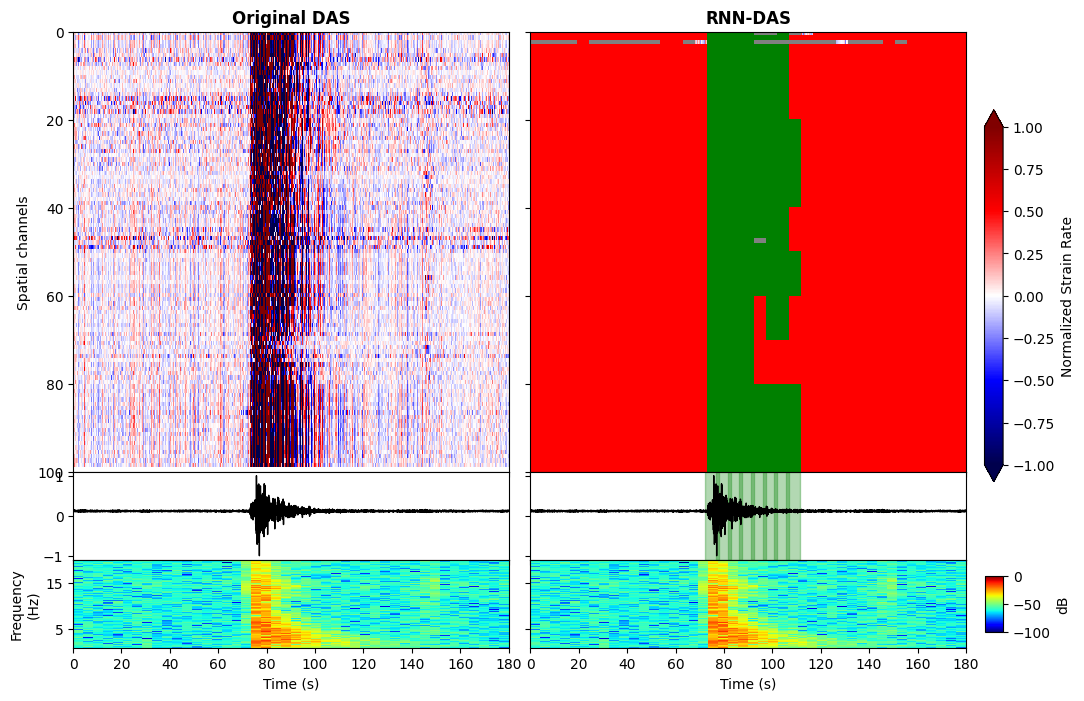

In [24]:
# Visualizing the predictions
plot_das_bi(data=H[:, :], probabilities=probabilities_grammar,  threshold=2/3, channel_idx=50)

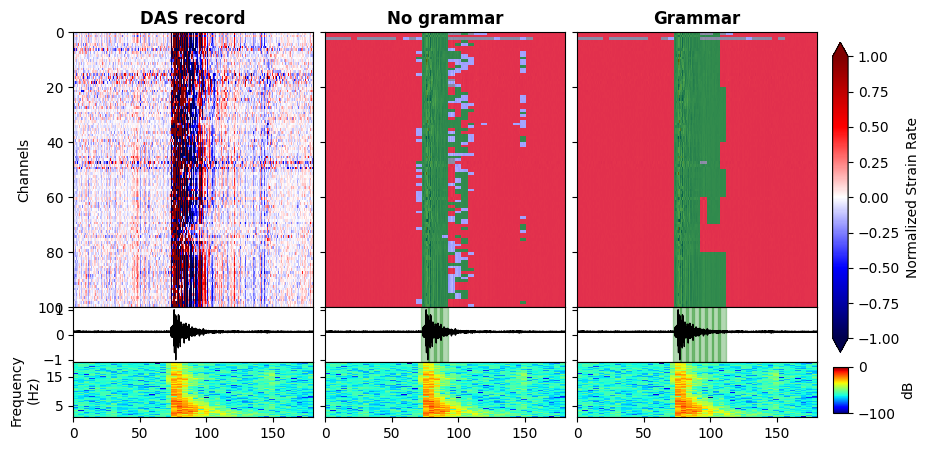

In [18]:
# No grammar vs grammar predictions visualization
plot_das_grammar(data=H[:, :], probabilities=probabilities, probabilities_grammar=probabilities_grammar,  window_duration=window_duration, overlap_duration=overlap_duration, threshold=2/3, channel_idx=50)

In [11]:
# Saving the predictions to pickle
event_id="d_c_20211120_064137_064337"
write_pickle(probabilities, os.path.join("RNN-DAS_predictions", f"{event_id}"))
write_pickle(probabilities_grammar, os.path.join("RNN-DAS_predictions", f"{event_id}_grammar"))


In [12]:
# Saving the detected phases to a csv
detect_phases(output_csv_name=event_id, start_date=start_time, probabilities=probabilities_grammar, fsamp=100, probability_threshold=2/3)

Events detected and saved in: RNN-DAS_picks\d_c_20211120_064137_064337
Total number of events detected: 101


In [13]:
# Reading the piked-phases
results=pd.read_csv(os.path.join(".", "RNN-DAS_picks", f"{event_id}_RNN-DAS.csv"))
results.head()

,channel_index,event_index,event_time,event_score,coda_index,coda_time,windows
0,0,7200,1970-01-01T00:01:12,1.000,9120,1970-01-01T00:01:31.200000,"[15, 16, 17, 18]"
1,0,10080,1970-01-01T00:01:40.800000,0.741,10560,1970-01-01T00:01:45.600000,[21]
2,1,7200,1970-01-01T00:01:12,0.938,10560,1970-01-01T00:01:45.600000,"[15, 16, 17, 18, 19, 20, 21]"
3,2,7200,1970-01-01T00:01:12,0.985,9120,1970-01-01T00:01:31.200000,"[15, 16, 17, 18]"
4,3,7200,1970-01-01T00:01:12,0.990,10560,1970-01-01T00:01:45.600000,"[15, 16, 17, 18, 19, 20, 21]"


In [14]:
# Extract the event waveforms and save them to a mseed file, where the channel corresponds to the DAS channel and maintins the origin time of the event
stream = extract_events_to_mseed(H, results, fsamp=100, threshold=0.9, output_file=f"{event_id}", network_code="LP", station_prefix="DAS", location_code="XX")
print(stream)

Saved extracted events to d_c_20211120_064137_064337
78 Trace(s) in Stream:

LP.DAS_0.XX.0000 | 1970-01-01T00:01:12.000000Z - 1970-01-01T00:01:31.190000Z | 100.0 Hz, 1920 samples
...
(76 other traces)
...
LP.DAS_96.XX.0096 | 1970-01-01T00:01:12.000000Z - 1970-01-01T00:01:50.390000Z | 100.0 Hz, 3840 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


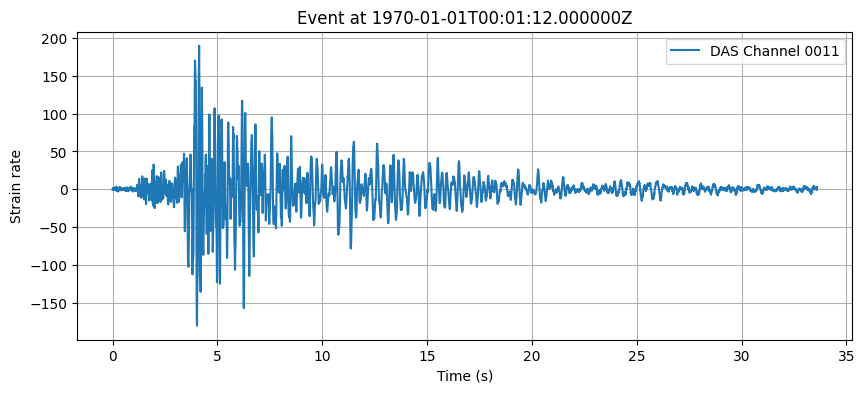

In [15]:
# Accessing traces 
trace = stream[10]  # You can change the index to view other traces

# Get data and timestamps
data = trace.data
times = np.linspace(0, len(data) / trace.stats.sampling_rate, len(data))

# Plot the trace
plt.figure(figsize=(10, 4))
plt.plot(times, data, label=f"DAS Channel {trace.stats.channel}")
plt.xlabel("Time (s)")
plt.ylabel("Strain rate")
plt.title(f"Event at {trace.stats.starttime}")
plt.legend()
plt.grid()
plt.show()


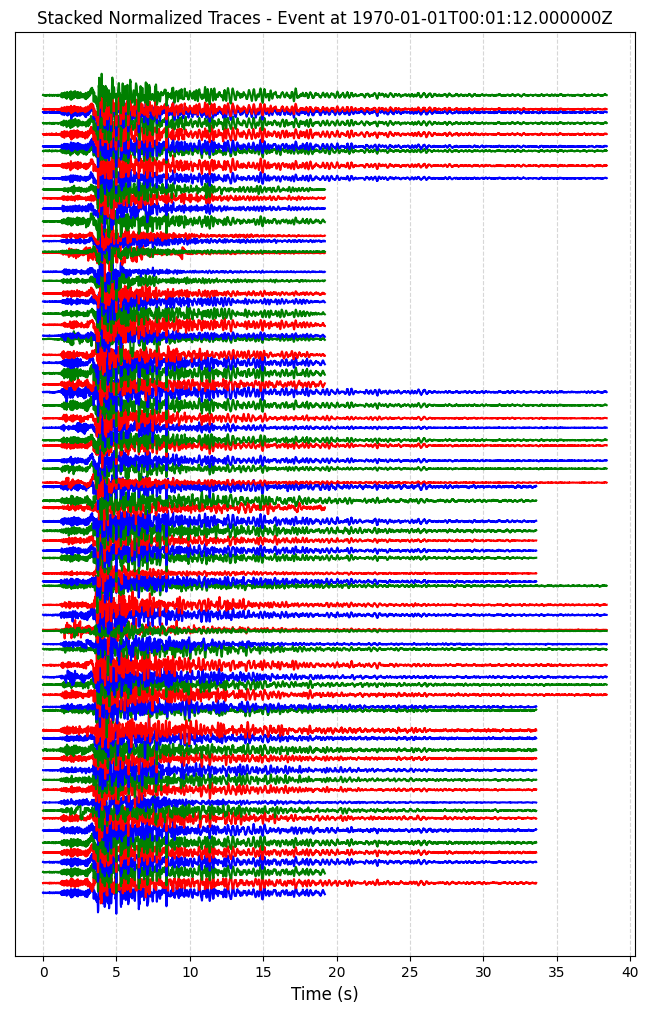

In [16]:
#Stack plot of all the detected event traces
plot_stacked_traces_normalized(stream)